## Image classification : Cats vs Dogs

### Objective: 

The objective of this exercise is to build a model that can identify whether a given image is that of a cat or a dog. We use the dataset from the kaggle competition and use Kaggle's GPU enabled Kernel to build a Neural Network model for classification. 

### Approach:

#### Input feature engineering through image processing



* As the initial step, training and test dataframes are created from all the images from the kaggle directories and Keras' ImageDataGenarator from the Image preprocessing module is used to generate batches of image data to be passed as tensor to the Nerual Network. A target image size of 256 by 256 pixels is considered with batch size of 40.

* The ImageDataGenarator also includes real-time data augmentation feature, where the input image data is augmented and passed on to the neural network. Essentially, the ImageDataGenerator takes in the user mentioned set of transformation values, applies it randomly to the input batch and replaces the original batch with the transformed batch of images. Examples of transformtion include random rotation, rescaling, shear, zooming, horizontal flip, fill mode, width shift and height shift.

#### Model architechture and Model settings

* The final model considered includes a pre-trained InceptionNet architechture with weights trained on the ImageNet dataset. Keeping the weights from the ImageNet, a fully connected hidden layer with 512 neurons is included on top of it ending with a layer of softmax activation as the final probability estimation layer. This model was trained to minimize categorical crossentropy using a Stochastic Gradient Descent optimizer with a learning rate of 0.0001, momentum of 0.9 and with nesterov accelaration through 10 epochs of batch size 32. 

### Codes

In [1]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications, optimizers, layers
from keras.applications import InceptionV3
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

print(os.listdir("/kaggle/input/dogs-vs-cats"))

Using TensorFlow backend.


['sampleSubmission.csv', 'train', 'test1']


###### Loading data and creating the input dataframe

In [2]:
files = os.listdir("/kaggle/input/dogs-vs-cats/train/train")

categories = []

for filename in files:
    c = filename.split('.')[0]
    if c == 'dog':
        categories.append(1)
    else:
        categories.append(0)

input_data = pd.DataFrame({
    'filename': files,
    'category': categories
})
input_data["category"] = input_data["category"].replace({0: 'cat', 1: 'dog'})
input_data.head()

,filename,category
0,dog.5743.jpg,dog
1,cat.10685.jpg,cat
2,cat.5263.jpg,cat
3,dog.8472.jpg,dog
4,cat.10632.jpg,cat


###### train and validation split

In [3]:
train_df, validate_df = train_test_split(input_data, test_size=0.2)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

###### Defining the ImageDataGenerator object

In [4]:
imgen_train = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_gen = imgen_train.flow_from_dataframe(
    train_df, 
    "/kaggle/input/dogs-vs-cats/train/train/", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(256, 256),
    batch_size=40
)

Found 20000 validated image filenames belonging to 2 classes.


In [5]:
imgen_val = ImageDataGenerator(rescale=1./255)
val_gen = imgen_val.flow_from_dataframe(
    validate_df, 
    "/kaggle/input/dogs-vs-cats/train/train/", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(256, 256),
    batch_size=40
)

Found 5000 validated image filenames belonging to 2 classes.


###### Defining the Neural Network Architechture

In [6]:
# loading the pre-trained InceptionNetV3 model
inception = InceptionV3(weights='imagenet', include_top=False)

get_output = inception.output
input_layer = GlobalMaxPooling2D()(get_output)

# Adding the fully connected layer with 512 neurons
fc_layer = Dense(512,activation='relu')(input_layer)

# Adding the final softmax layer
final_layer = Dense(2, activation='softmax')(fc_layer)

final_model = Model(inception.input, final_layer)

for layer in final_model.layers[:172]:
    layer.trainable =False
for layer in final_model.layers[172:]:
    layer.trainable=True

# compiling the final model with Stochastic Gradient Descent optimizer
final_model.compile(loss='categorical_crossentropy',
              optimizer= optimizers.SGD(lr=1e-4, momentum=0.9, nesterov = True),
              metrics=['accuracy'])

87916544/87910968 [==============================] - 7s 0us/step


In [7]:
check = ModelCheckpoint(filepath = '../working/best.hd5', monitor = 'val_loss', save_best_only = True, mode = 'auto',)
es = EarlyStopping(monitor='val_loss',patience=11,mode=min,restore_best_weights=True)

callbck = [es, check]

/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:788: RuntimeWarning: EarlyStopping mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


##### Fitting the model

In [8]:
history = final_model.fit_generator(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    validation_steps=total_validate//40,
    steps_per_epoch=total_train//40,
    callbacks = callbck,
    class_weight='auto')

Epoch 1/10
500/500 [==============================] - 431s 862ms/step - loss: 0.1790 - accuracy: 0.9253 - val_loss: 0.0618 - val_accuracy: 0.9876
Epoch 2/10
500/500 [==============================] - 359s 719ms/step - loss: 0.0979 - accuracy: 0.9609 - val_loss: 0.0302 - val_accuracy: 0.9880
Epoch 3/10
500/500 [==============================] - 357s 715ms/step - loss: 0.0839 - accuracy: 0.9671 - val_loss: 0.0088 - val_accuracy: 0.9906
Epoch 4/10
500/500 [==============================] - 366s 732ms/step - loss: 0.0725 - accuracy: 0.9714 - val_loss: 0.0071 - val_accuracy: 0.9894
Epoch 5/10
500/500 [==============================] - 365s 729ms/step - loss: 0.0661 - accuracy: 0.9740 - val_loss: 0.0075 - val_accuracy: 0.9894
Epoch 6/10
500/500 [==============================] - 357s 714ms/step - loss: 0.0590 - accuracy: 0.9779 - val_loss: 0.0044 - val_accuracy: 0.9902
Epoch 7/10
500/500 [==============================] - 356s 711ms/step - loss: 0.0519 - accuracy: 0.9796 - val_loss: 0.0104 -

###### Best scenario of validation accuracy

In [9]:
loss, accuracy = final_model.evaluate_generator(val_gen, total_validate//40, workers=12)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Validation: accuracy = 0.991600  ;  loss = 0.001994 


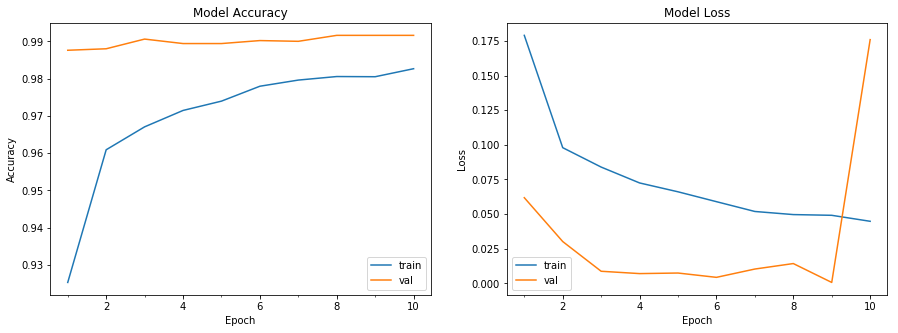

In [10]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # First plot to observe model accuracy
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # second plot to observe model loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

we observe that with higher number of epochs the training accuracy significantly increased and training loss significantly decreased

###### Loading test data

In [18]:
test_files = os.listdir("/kaggle/input/dogs-vs-cats/test1/test1")
test_data = pd.DataFrame({
    'filename': test_files
})
n = test_data.shape[0]

In [12]:
imgen_test = ImageDataGenerator(rescale=1./255)
test_gen = imgen_test.flow_from_dataframe(
    test_data, 
    "/kaggle/input/dogs-vs-cats/test1/test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=40,
    target_size=(256, 256),
    shuffle=False
)

Found 12500 validated image filenames.


###### Predictions on the test data

In [13]:
prd = final_model.predict_generator(test_gen, steps=np.ceil(n/40))
threshold = 0.5

In [19]:
predict_df = pd.DataFrame.from_records(prd)
predict_df.head(2)
test_data['category'] = predict_df[1]
test_data.head(2)

,filename,category
0,6163.jpg,0.999752
1,4466.jpg,0.999092


###### Sample predictions on test data

In [26]:
st = test_data.iloc[230:250,:]
st.reset_index(inplace=True)
st.loc[st['category']>=0.5,'categ'] = 'Dog'
st.loc[st['category']<0.5,'categ'] = 'Cat'
st = st.head(18)

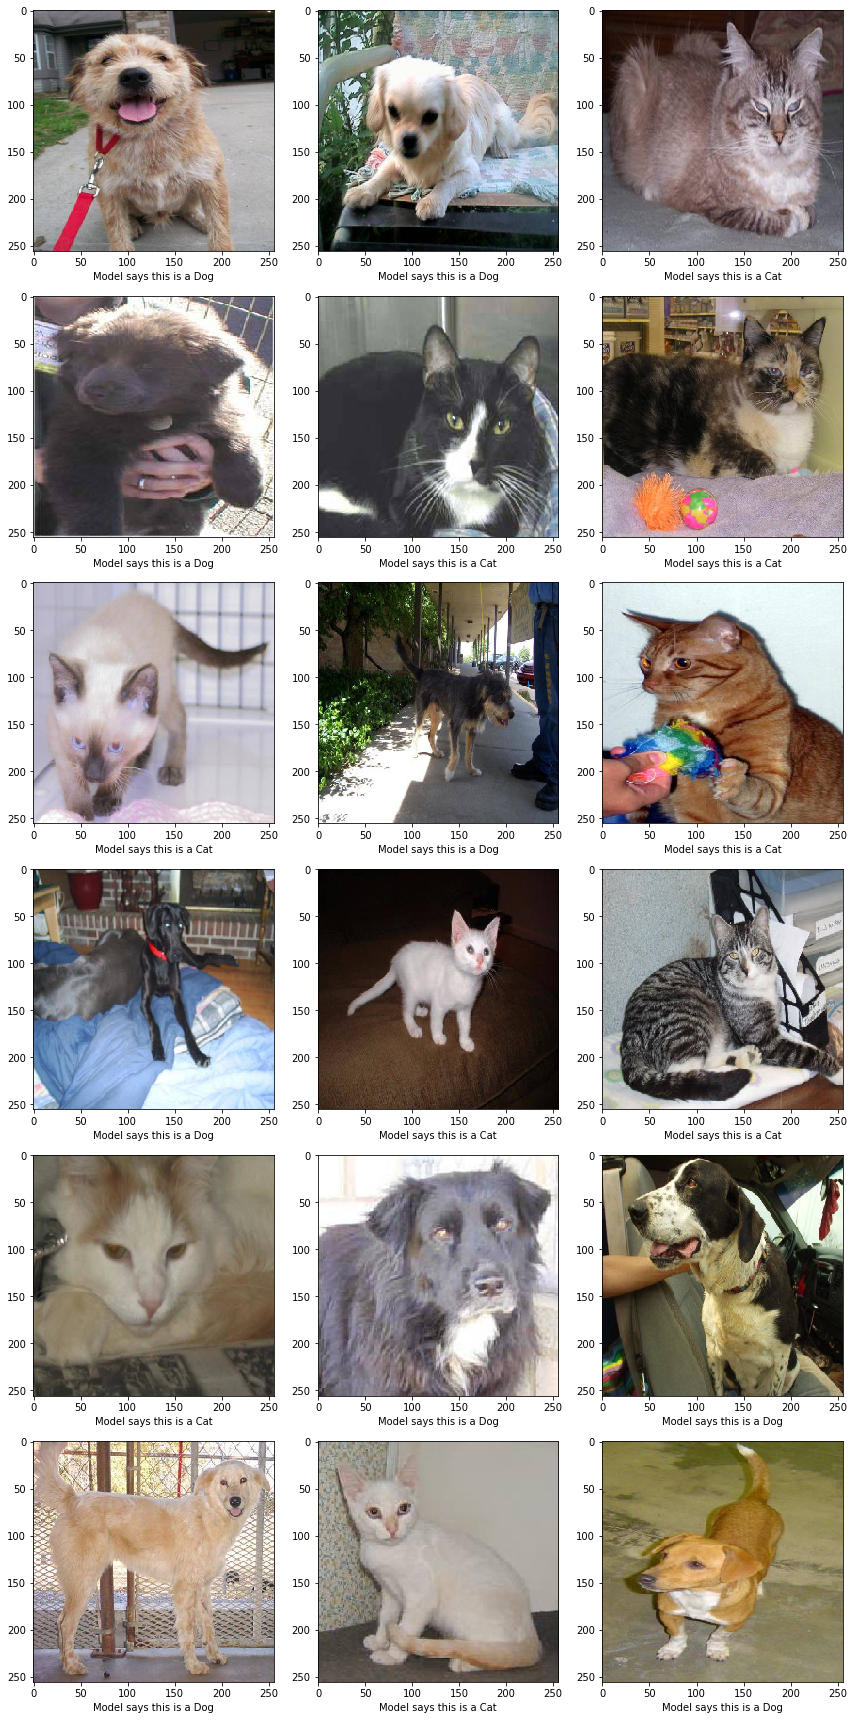

In [27]:
plt.figure(figsize=(12, 24))
for index, row in st.iterrows():
    filename = row['filename']
    category = row['categ']
    img = load_img("/kaggle/input/dogs-vs-cats/test1/test1/"+filename, target_size=(256,256))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel('Model says this is a ' + "{}".format(category))
plt.tight_layout()
plt.show()